# Expansion velocity of the universe

In 1929, Edwin Hubble published a [paper](http://www.pnas.org/content/pnas/15/3/168.full.pdf) in which he compared the radial velocity of objects with their distance. The former can be done pretty precisely with spectroscopy, the latter is much more uncertain. His original data are [here](table1.txt).

He saw that the velocity increases with distance and speculated that this could be the sign of a cosmological expansion. Let's find out what he did.

First, the usual python imports:

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### Exercise 1:

Load the data into an array with `numpy.genfromtxt`, make use of its arguments `names` and `dtype` to read in the column names from the header and choosing the data type on its own as needed. You should get 6 columns
   * `CAT`, `NUMBER`:  These two combined give you the name of the galaxy.
   * `R`: distance in Mpc
   * `V`: radial velocity in km/s
   * `RA`, `DEC`: equatorial coordinates of the galaxy
   
Make a scatter plot of V vs R. Don't forget labels and units...

In [9]:
# load file into variable `data` ...
data = np.genfromtxt('table1.txt', dtype = None, names = True, encoding ='utf8')
data

array([('Mag', 'S', 0.032,  170, '00:51:00', '-73:06:00'),
       ('Mag', 'L', 0.034,  290, '05:24:00', '-69:48:00'),
       ('NGC', '6822', 0.214, -130, '19:44:58', '-14:48:12'),
       ('NGC', '598', 0.263,  -70, '01:31:02', '30:24:15'),
       ('NGC', '221', 0.275, -185, '00:39:58', '40:35:20'),
       ('NGC', '224', 0.275, -220, '00:40:00', '40:59:43'),
       ('NGC', '5457', 0.45 ,  200, '14:01:26', '54:35:18'),
       ('NGC', '4736', 0.5  ,  290, '12:48:32', '41:23:32'),
       ('NGC', '5194', 0.5  ,  270, '13:27:46', '47:27:10'),
       ('NGC', '4449', 0.63 ,  200, '12:25:45', '44:22:12'),
       ('NGC', '4214', 0.8  ,  300, '12:13:09', '36:36:17'),
       ('NGC', '3031', 0.9  ,  -30, '09:51:27', '69:18:08'),
       ('NGC', '3627', 0.9  ,  650, '11:17:39', '13:15:56'),
       ('NGC', '4826', 0.9  ,  150, '12:54:16', '21:57:12'),
       ('NGC', '5236', 0.9  ,  500, '13:34:12', '-29:36:39'),
       ('NGC', '1068', 1.   ,  920, '02:40:07', '-00:13:32'),
       ('NGC', '5055', 1.1  

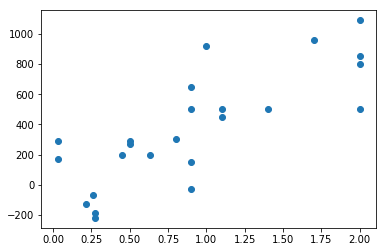

In [5]:
# make scatter plot
plt.scatter(data['R'], data['V'])

### Exercise 2:

Use your knowledge of linear first to determine the slope $H_0$ of the line $V=H_0 R$. This is a linear model **with no intercept**. For that, reshape $R$ as a $N\times1$ design matrix and solve for 1 unknown parameter. Then, update the plot by adding the best-fit line.

[423.93732323]


/home/ishanikulkarni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


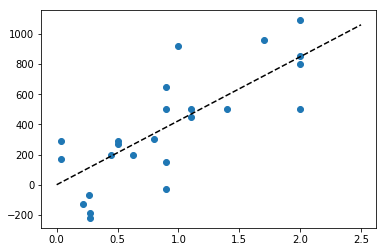

In [8]:
N = len(data)
R = data['R'].reshape(N, 1)
R

X = data['R'].reshape((N,1))
params, _, _, _ = np.linalg.lstsq(X, data['V'])
print(params)
H0 = params[0]

R = np.linspace(0,2.5,100)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data['R'], data['V'])
ax.plot(R, H0*R, 'k--')

Can you guess the cause for the scatter with respect to the best-fit curve? Is it fair or even appropriate to fit only for the slope and not also for the intercept? How would $H_0$ change if you include an intercept in the fit?

In [11]:
X = np.ones((N, 2))
X[:,1] = data['R']
params, _, _, _ = np.linalg.lstsq(X, data['V'])
print(params)
inter, H0 = params

R = np.linspace(0,2.5,100)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data['R'], data['V'])
ax.plot(R, H0*R + inter, 'k--')
ax.set_xlim(xmin=0, xmax=2.5)
ax.set_xlabel('Distance [Mpc]')
ax.set_ylabel('Velocity [km/s]')

(array([-40.7836491 , 454.15844092]), array([1193442.36627214]), 2, array([6.98607217, 2.17085022]))


/home/ishanikulkarni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: too many values to unpack (expected 2)

## Correcting for motion of the sun

$V$ as given in the table is a combination of any assumed cosmic expansion and the motion of the sun with respect to that cosmic frame. So, we need to generalize the model to $V=H_0 R + V_s$, where the solar velocity is given by $V_s = X \cos(RA)\cos(DEC) + Y\sin(RA)\cos(DEC)+Z\sin(DEC)$. We'll use `astropy` to read in the RA/DEC coordinate strings and properly convert them to degrees (and then radians):

In [12]:
import astropy.coordinates as coord
import astropy.units as u
import numpy as np

pos = coord.SkyCoord(ra=data['RA'].astype('U8'), dec=data['DEC'].astype('U9'), unit=(u.hourangle,u.deg),frame='fk5')
ra_ = pos.ra.to(u.deg).value * np.pi/180
dec_ = pos.dec.to(u.deg).value * np.pi/180

### Exercise 3:

Construct a new $N\times4$ design matrix for the four unknown parameters $H_0$, $X$, $Y$, $Z$ to account for the solar motion. The resulting $H_0$ is Hubble's own version of the "Hubble constant". What do you get?

In [16]:
Ah = np.column_stack((data['R'], np.cos(ra_)*np.cos(dec_), np.sin(ra_)*np.cos(dec_), np.sin(dec_)))
params_h, _, _, _ = np.linalg.lstsq(Ah, data['V'])
print(params_h)
H0 = params_h[0] 

[ 465.17797833  -67.84096674  236.14706994 -199.58892695]


/home/ishanikulkarni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


Make a scatter plot of $V-V_S$ vs $R$. How is it different from the previous one without the correction for solar velicity. Add the best-fit linear regression line.

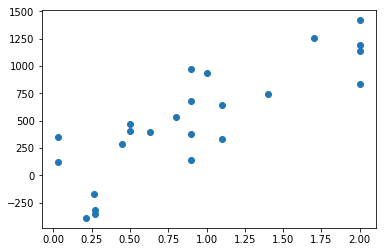

In [17]:
VS = params_h[1]*data['R'] + params_h[2]*np.cos(ra_)*np.cos(dec_) + params_h[3]*np.sin(ra_)*np.cos(dec_)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data['R'], data['V'] - VS)

### Exercise 4:

Using `astropy.units`, can you estimate the age of the universe from $H_0$? Does it make sense?

In [18]:
H0q = H0 * u.km / u.s / u.Mpc
(1./H0q).to(u.Gyr)

<Quantity 2.10197444 Gyr>

## Measurement errors

So far we have not incorporated any measurement uncertainties. 

###  Exercise 5:
Can you guess or estimate them from the scatter with respect to the best-fit line? You may want to look at the residuals with respect to the best-fit model.

With this error estimate, construct a covariance matrix $\Sigma$ and repeat the linear regression, this time with errors, to get a new estimate of $H_0$. Has it changed?

### Exercise 6:

Compute the parameter covariance matrix and read off the variance of $H_0$. Update your plot to illustrate that uncertainty.

How large is the relative error?  Would that help with the problematic age estimate above? If not, what do you think is going on?